In [168]:
from numpy.random import normal
from numpy import asarray, vstack, concatenate
from numpy import mean
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split

import pandas as pd
import random

import shap
from sklearn.ensemble import RandomForestRegressor


import fatf
fatf.setup_random_seed(42)
import fatf.transparency.predictions.surrogate_explainers as surrogates
import fatf.vis.lime as fatf_vis_lime

20-Jul-21 19:18:14 fatf         INFO     Seeding RNGs using the input parameter.
20-Jul-21 19:18:14 fatf         INFO     Seeding RNGs with 42.


# Understanding the causal structures in our data and how it affects interpretability 

In explainable AI there has been some serious debate recently as to whether you can have explainability without casusality. Unfortunately, the true cuasal graph of a real world system is unknown. When we take observations surrounding a system we have limited intuition as to how each variable interacts. This uncertainty is exacerbated when bulding predictive models.

Predictictive machine learning exploits and selects patterns in observational data to predict a target variable. A machine learning model therefore does not care if a variable is causally related to an outcome, it merely exploits the correlations in the data to optimise performance in some way. 

The problem arises when these correlation based models are interpreted in a causal way. Below we exemplify the assumptions made by machine learning predictive models and how the parameters cannot be interpreted in causal way.

Similary, many explainable AI techniques particularly those concerned with feature importance, exploit correlations in the data and machine learning model to output explanations in the form: "feature X was more important than feature Y in causing outcome X". This is a huge problem, firstly as the word 'explanation' implies some form of causal reasoning when in reality nothing of the sort has been  done. Secondly, correlations are extremely sensitive to the model setup therefore any associated interpretations of the model's behaviour are also highly sensitive and lack robustness. 

Below we explore the effects of the assumptions implicity made by ''interpretable'' machine learning models and interpretability techniques such as SHAP and show how these result in interpretations that do not account for complex dependency behaviour in the underlying data and associated model. 

This part of my research is therefore concerned with identifying causal structures in observational data and understanding how these can be used to create interpretable predictive models. Obviously this is a massive challenge so we're starting small with a deepdive into the problems facing correlation based explainable AI and how causal discovery algorithms may aid robustness.

## A brief introduction to causal data structures

In the mid 1980s a group from UCLA decided that it was beneficial to think about the uncertainty of a system in terms of the conditional dependencies of the components of that system.

For example consider you have a dodgy car that could only break down thanks to either running out of fuel or a flat battery. Imagine that you wake up one morning to find your car unable to start, you have no idea if you have a flat battery or if you have run out of fuel! Now imagine the same scenario but you filled your car up with petrol the night before. Now, given the fact you know your car is full of fuel you are certain that your car has broken down thanks to a flat battery. 

By applying this line of thinking to an AI systems with multiple components, we can use the conditional dependencies between them to encode our uncertainty in the overall system. 

### D-separation

D-separation is the algorithm composed by Pearl et al. that computes all the conditional independencies between the components of a system, capable of being expressed graphically as a Directed Acyclic Graph or DAG (for a primer on these graphs, see Chapter 6.1 from "Elements of Causal Inference". PDF available at https://library.oapen.org/bitstream/id/056a11be-ce3a-44b9-8987-a6c68fce8d9b/11283.pdf. 

If two variables are d-separated thanks to a set of variables $Z$, then they are independent conditional on $Z$ in <b> all </b> probability distributions that are capable of being enatiled from that DAG. Intuitively, two variables $X$ and $Y$ are independent conditional on $Z$ if knowing knowledge of $Y$ tells you nothing extra about $Z$ after knowing $X$. In relation to our dodgy car scenario outlined above:
    <ul>
    <li> $X:$ Car battery being flat </li>
    <li> $Y:$ No fuel in tank </li>
    <li> $Z:$ Car won't start </li>
        </ul>

Now, clearly, $X$ and $Y$ are <b> NOT </b> independent given $Z$ seeing as if we know that the car wont start and that our tank is full, we know that the car battery must be flat. In other words, knoweldge about $Y$ gives us extra information about $X$ now that we know $Z$.

This is a very trivial example with only 3 variables. However, in real systems we are likely to have a much larger number of components with complex dependency relationships. The d-separation algorithm, therefore encapsulates all the possible dependency relationships between two variables in an efficient way. 

There is a dependency between two variables if there exists a path between them that carries information, aka an active path. Its possible that in real systems there would be a large numebr of paths between two variables, however $X$ and $Y$ share a dependency if there is <b> any </b> active path between them. 

A path is active if <b> every </b> vertex on that graph is active relative to a set of vertices. The following ideas are best understood via an example, so, if we take $X$, $Y$ and $Z$ from above, consider all the possible paths from $X$ to $Y$ via an intermediate $Z$
    <ul>
    <li>1. $X \rightarrow Z \rightarrow Y$ </li>
    <li>2.  $X \leftarrow Z \rightarrow Y$ </li>
    <li>3.  $X \rightarrow Z \leftarrow Y$ (common cause) </li>
    <li>4.  $X \rightarrow Z \leftarrow Y$ (common effect) </li>
    </ul>
        
  
Now, we want to know whether there is any flow of dependecy from $X$ to $Y$ relative to a set of variables. As stated before, if there exists one active path between $X$ and $Y$ given a set of variables $Z*$ then $X$ and $Y$ are not d-sepearated, they are d-connected. Therefore, if there do not exist any active paths between $X$ and $Y$ then the two variables have no flow of dependency and are d-separated (independent). 

For simplicity, let's first consider the empty set of vertices such that $Z* = \{\}$. 

The first 3 paths in the example above are active, i.e. without knowing $Z$, knowing $X$ tells us more about $Y$ (or vice versa). The 4th path in the example above is an inactive path as knowing $X$ tells us nothing about $Y$. This type of path is also called a <b> collider </b>. 

It follows that when the conditioning set is empty ($Z* = \{\}$). X and Y are dependent if there are any paths between them that have no colliders. 

Now lets consider the same example but include Z within the conditioning set, $Z* = \{Z\}$. 

The first 3 paths in the exmaple above are now inactive as knowing about $X$ after we learn about $Z$ tells us nothing about $Y$ (or vice versa). 
The 4th path, however, is now active as knowing $X$ after knowing Z tells us about $Y$ (think through the dodgy car example again if confused). 

By conditioning on a collider, we activate the path between two variables. Furthermore, conditioning on the descendent of a collider also activates the path. 

The algorithm for d-separation increases in complexity as we add vertices to the graph. However, if we find two variables that are d-separated given a set of vertices, Pearl et al. showed that these two variables, will be conditionally independent in any probability distribution entailed by the graph. 

This is an extremely desirable property as we can use this knowledge to infer the causal mechanisms of a system. 

## How well do state-of-the-art interpretability methods deal with causal structures in data?

As a framework for feature importance, Shapley values ignore all causal structure between variables. Frye et al. attempt to incrporate causal reasoning into the SHAP framework by relaxing the symmetry property. This research attempts to look at the type of causal relationship, how SHAP deals with feature importance for each of these and what we may expect out of an explanation for each causal relationship. 

### Shapley Values for local explaantions

A team of $N$ players work collaboratively to achieve an amount of value $v(N)$. The Shapley value for each player, $\phi_{v}(i)$ computes the amount of contribtion player $i$ has towards goal $V(N)$:
    $$ \phi_{v}(i) = \sum_{S \subseteq N \backslash i}\frac{s!(n-s-1)!}{n!}[v(S \cup i) - v(S)] $$

Intuitively, this definition captures the idea that $\phi_{v}(i)$ measures the marginal contribution that player $i$ makes upon joining the team, averaged over all orders in which the team can be formed.

Converting the above idea into a framework for measuring feature importance was introduced in 

The central challenge is to define the behaviour of the function $v$ for the predictive model when applied to subgroups of features. This can be done in the following way:

$$ vf_{y}(S) = \mathbb{E}_p(x')[f_{y}(x_{S} \sqcup x'_{\bar{S}}] $$

where function $vf$ predicts labels $y$ for a subset of feature vectors $S$. The expectation is taken over $p(x')$ - the probablity distribution of the set of samples. The union $ X_{S} \sqcup X'_{\bar{S}} $ reflects the joining of the within subgroup features from $x$ with the out of subgroup features from $x'$. This definition is problematic as it ignores all covariance structure between features. 

## Types of Causal structure

The four different causal relationships between two variables $X$ and $Y$ and intermediate variable $Z$ are defined as:
 <ul>
    <li>1. $X \rightarrow Z \rightarrow Y$ </li>
    <li>2.  $X \leftarrow Z \rightarrow Y$ </li>
    <li>3.  $X \rightarrow Z \leftarrow Y$ (common cause) </li>
    <li>4.  $X \rightarrow Z \leftarrow Y$ (common effect) </li>
 </ul>
 
Below we create simple synthetic datasets representing each of the above causal relations. We then use SHAP to generate feature importance explanations both globally and locally to explore how SHAP generates explanations for predictions with different causal mechanisms in the underlying data. 

### 1) Causal Structure: X -> Z -> Y

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


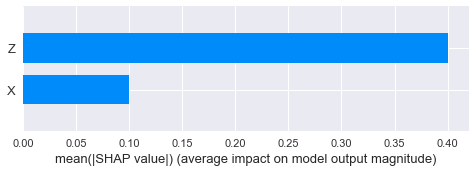

In [169]:
df_feature = pd.DataFrame()
df_feature['X'] = asarray([normal(0,10) for x in range(0,100)])
df_feature['Z'] = asarray([normal(0,1) for x in range(0,100)]) + df_feature['X']
Y = asarray([1 if x > mean(df_feature['Z']) else 0 for x in df_feature['Z']])
data = df_feature.values

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1, random_state=42)
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=['X','Z'], plot_type="bar")

### 2) Causal Structure: X <- Z <- Y

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


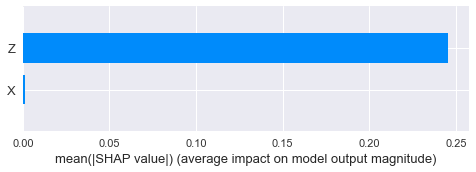

In [170]:
df_feature = pd.DataFrame()
Y = asarray([random.randint(0,1) for x in range(0,100)])
df_feature['Z'] = asarray([normal(0,1) for x in range(0,100)]) + Y
df_feature['X'] = asarray([1 if x > mean(df_feature['Z']) else 0 for x in df_feature['Z']])
data = df_feature.values

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1, random_state=42)
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=['Z','X'], plot_type="bar")

In [171]:
### 3) Causal Structure: X -> Z <- Y

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


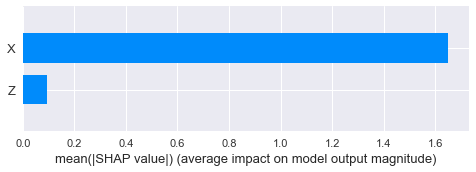

In [172]:
df_feature = pd.DataFrame()

Y = asarray([random.randint(0,10) for x in range(0,100)])
df_feature['X'] = asarray([normal(0,1) for x in range(0,100)])
df_feature['Z'] = asarray([1 if ( x > mean(df_feature['X']) or x > mean(Y)) else 0 for x in df_feature['X']])
data = df_feature.values

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1, random_state=42)
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=['X','Z'], plot_type="bar")

In [173]:
### 4) Causal Structure: X <- Z -> Y

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


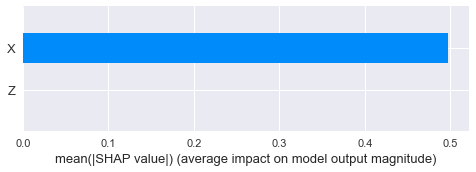

In [174]:
df_feature = pd.DataFrame()

df_feature['Z'] = asarray([normal(0,1) for x in range(0,100)])
df_feature['X'] = asarray([normal(0,1) for x in range(0,100)]) + Z
Y = asarray([1 if x > mean(df_feature['Z']) else 0 for x in df_feature['Z']])


data = df_feature.values

X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.1, random_state=42)
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=['X','Z'], plot_type="bar")

## Discussion of Results

TODO

## Discussion of [FRYE2019ASYMMETRIC]

TODO

## References


[PETERS2017ELEMENTS] Peters, Jonas, Dominik Janzing, and Bernhard Schölkopf. Elements of causal inference. The MIT Press, 2017.

[LUNDBERG2017UNIFIED] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Advances in Neural Information Processing Systems. 2017

[FRYE2019ASYMMETRIC] Frye, Christopher, Ilya Feige, and Colin Rowat. "Asymmetric Shapley values: incorporating causal knowledge into model-agnostic explainability." arXiv preprint arXiv:1910.06358 (2019).